In [1]:
ENV["GKS_ENCODING"] = "utf-8"
using NLsolve
using Plots
using SharedArrays

using Pkg
using HDF5
Pkg.activate("/home/julian/Hamburg/LadderDGA.jl")
using LadderDGA
using Logging

cfg_file = "/home/julian/Hamburg/lDGA_checks/spch_inf/config.toml";

  Activating project at `~/Hamburg/LadderDGA.jl`


In [2]:
mP, sP, env, kGrids, qGridLoc, freqList = readConfig(cfg_file)
kG = kGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp, GLoc, GLoc_fft, Σ_loc, FUpDo  = setup_LDGA(kG, freqList, mP, sP, env);

┌ Info: Reading Inputs...
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/IO.jl:7
┌ Info: setting usable ranges of sp and ch channel from 34:268 and 32:270 to the same range of 34:268
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:137
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(34:268) = 0.3287, χLoc_ch(34:268) = 0.1633 
│ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.2459680094732252 ?≈? 0.2489450803337799 ?=? 0.24885137857275672 ?≈? 0.25"
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:160


In [3]:
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp, qGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp, FUpDo,
    qGridLoc, sumHelper_f, mP, sP)[:,1] .+ mP.n * mP.U/2.0;

# ladder quantities
bubble = calc_bubble(νGrid, GLoc_fft, kG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, kG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, kG, νGrid, sumHelper_f, -mP.U, mP, sP);

nlQ_sp_nλ = nlQ_sp#deepcopy(nlQ_sp)
nlQ_ch_nλ = nlQ_ch#deepcopy(nlQ_ch);

In [4]:
#λ_correction!(:sp, impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, kG, mP, sP)
#Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, kG, sumHelper_f, mP, sP)
#Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)];

## k-dependent behavior

In [ ]:
λsp_check_n = 50
nh    = ceil(Int64, size(bubble,1)/2)
λsp_of_k = Array{Float64}(undef, length(kGrids))
χsp_of_k = Array{Float64}(undef, length(kGrids), size(bubble,1))
χspλ_of_k = Array{Float64}(undef, length(kGrids), size(bubble,1))
χch_of_k = Array{Float64}(undef, length(kGrids), size(bubble,1))
λsp_check_of_k = Array{Float64}(undef, length(kGrids), size(bubble,1))
sum_freq = LadderDGA.sum_freq
subtract_tail = LadderDGA.subtract_tail
kintegrate = LadderDGA.kintegrate
χ_λ = LadderDGA.χ_λ


for (i,kGi) in enumerate(kGrids)
    νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp, GLoc_i, GLoc_fft_i, Σ_loc, FUpDo  = setup_LDGA(kGi, freqList, mP, sP, env);
    bubble_i = calc_bubble(νGrid, GLoc_fft_i, kGi, mP, sP);
    nlQ_sp_i = calc_χ_trilex(impQ_sp.Γ, bubble_i, kGi, νGrid, sumHelper_f, mP.U, mP, sP);
    nlQ_ch_i = calc_χ_trilex(impQ_ch.Γ, bubble_i, kGi, νGrid, sumHelper_f, -mP.U, mP, sP);
    χsp_of_k[i,:] = real.(LadderDGA.kintegrate(kGi, nlQ_sp_i.χ, dim=2)[:,1])
    λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp_i, nlQ_ch_i, bubble_i, GLoc_fft_i, kGi, mP, sP)
    λsp_of_k[i] = λ_sp
    
    χspλ_of_k[i,:] = real.(LadderDGA.kintegrate(kGi, nlQ_sp_i.χ, dim=2)[:,1])
    χch_of_k[i,:] = real.(LadderDGA.kintegrate(kGi, nlQ_ch_i.χ, dim=2)[:,1])
    χsp_min    = -minimum(1 ./ real.(nlQ_sp_i.χ[nh,:])) .+ 0.01
    usable_ω = intersect(nlQ_sp_i.usable_ω, nlQ_sp_i.usable_ω)
    iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[usable_ω] .* π ./ mP.β
    f(λint) = sum_freq(subtract_tail(kintegrate(kGi, χ_λ(real.(nlQ_sp_i.χ[usable_ω,:]), λint), dim=2)[:,1],mP.Ekin_DMFT, iωn), [1], Naive(), mP.β, corr=-mP.Ekin_DMFT*mP.β^2/12)[1] - mP.n * (1 - mP.n/2)

    for j in range(χsp_min,stop=χsp_min+2,length=λsp_check_n)
    end
end
plot(λsp_of_k, title="λsp(k)")

In [ ]:
plot(χch_of_k[1,:], markershape=:auto, title="χch(k)")
plot!(χch_of_k[2,:], markershape=:auto)
plot!(χch_of_k[3,:], markershape=:auto)
plot!(χch_of_k[4,:], markershape=:auto)
plot!(χch_of_k[5,:], markershape=:auto)
plot!(χch_of_k[6,:], markershape=:auto)

In [ ]:
plot(χsp_of_k[1,:], markershape=:auto, title="χsp(k)")
plot!(χsp_of_k[2,:], markershape=:auto)
plot!(χsp_of_k[3,:], markershape=:auto)
plot!(χsp_of_k[4,:], markershape=:auto)
plot!(χsp_of_k[5,:], markershape=:auto)
plot!(χsp_of_k[6,:], markershape=:auto)

In [ ]:
Σ_νRange = sP.n_iν+1
Σ_ladder_full = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, kG, sumHelper_f, mP, sP)
Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, kG, sumHelper_f, mP, sP)[sP.n_iν+1:end,:]
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)];
plot(0:sP.n_iν-1, imag(Σ_ladder[:,1]), markershape=:auto)
plot!(0:sP.n_iν-1, imag(Σ_ladder_corrected[:,1]), markershape=:auto)
plot!(0:sP.n_iν-1, imag(Σ_loc[1:size(Σ_ladder,1)]), markershape=:auto)
plot!(0:sP.n_iν-1, imag(Σ_ladderLoc[1:size(Σ_ladder,1)]), markershape=:auto)

# Preparation

For the extended $\lambda$ correction, we need to compute ladder kinetic and potential energy of the system and also compute the DMFT kinetic energy (for improved sums)

# Cond 1 Test
## λsp(λch)

In [4]:
nh = ceil(Int64, size(nlQ_ch.χ,1)/2)
λch_min = -1 / maximum(real.(nlQ_ch_nλ.χ[nh,:]))
λsp_min = -1 / maximum(real.(nlQ_sp_nλ.χ[nh,:]))
println("estimated smallest vaue for λ λsp ≈ $(λsp_min), λch ≈ $(λch_min)")

estimated smallest vaue for λ λsp ≈ -0.040106801269600145, λch ≈ -3.848271894028831


In [17]:
χ_λ! = LadderDGA.χ_λ!
kintegrate = LadderDGA.kintegrate
subtract_tail = LadderDGA.subtract_tail
Naive = LadderDGA.Naive
kGrid = kG
ωindices = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[ωindices] .* π ./ mP.β
χch_λ = Array{Complex{Float64},2}(undef,length(ωindices), size(nlQ_sp.χ,2))
λch_range = λch_min+0.02:0.02:-3.3
spOfch_max_nl = zeros(length(λch_range))
χupdo_ω = Array{eltype(nlQ_sp.χ),1}(undef, length(ωindices))
χupup_ω = Array{eltype(nlQ_sp.χ),1}(undef, length(ωindices))

for (λi,λchi) in enumerate(λch_range)
    χsp_λ = real.(deepcopy(nlQ_sp_nλ.χ[ωindices,:]))
    χ_λ!(χch_λ, nlQ_ch_nλ.χ[ωindices,:], λchi)
    χch_ω = kintegrate(kGrid, χch_λ, dim=2)[:,1]
    χch_ω_sub = subtract_tail(χch_ω, mP.Ekin_DMFT, iωn)
    χch_sum = real(sum_freq(χch_ω_sub, [1], Naive(), mP.β, corr=-mP.Ekin_DMFT*mP.β^2/12)[1])
    rhs_val = (mP.n) * (1 - mP.n/2) - χch_sum
    spOfch_max_nl[λi] = LadderDGA.λsp(χsp_λ, iωn, mP.Ekin_DMFT, rhs_val, kGrid, mP)
end

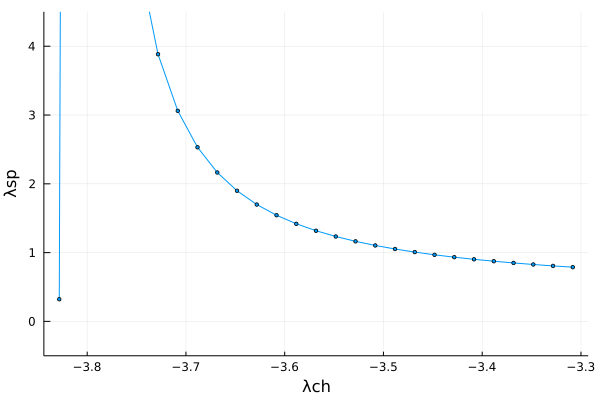

In [18]:
plot(λch_range, spOfch_max_nl, ylims=(-0.5,4.5), markershape=:circle, markersize=2, xlabel="λch", ylabel="λsp", label="")

# cond2
## λsp(λch)

In [19]:
Σ_internal! = LadderDGA.Σ_internal!
iν_array = LadderDGA.iν_array
calc_Σ_ω! = LadderDGA.calc_Σ_ω!
G_from_Σ = LadderDGA.G_from_Σ
flatten_2D = LadderDGA.flatten_2D
Naive = LadderDGA.Naive
extend_tmp! = LadderDGA.extend_tmp!

nlQ_sp = deepcopy(nlQ_sp_nλ)
nlQ_ch = deepcopy(nlQ_ch_nλ)
Gνω = GLoc_fft
kGrid = kG

ωindices = (sP.dbg_full_eom_omega) ? (1:size(bubble,1)) : intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[ωindices] .* π ./ mP.β
sh_f = get_sum_helper(2*sP.n_iν, sP, :f)
sh_b = Naive() #get_sum_helper(length(ωindices), sP, :b)

tmp = SharedArray{Float64,3}(length(ωindices), size(bubble,2), size(bubble,3))
Σ_ladder_ω = SharedArray{Complex{Float64},3}( size(bubble,3), size(bubble,2), length(ωindices))
χupdo_ω = SharedArray{eltype(nlQ_sp.χ),1}(length(ωindices))
χupup_ω = SharedArray{eltype(nlQ_sp.χ),1}(length(ωindices))
nlQ_ch_int = deepcopy(nlQ_ch)
nlQ_sp_int = deepcopy(nlQ_sp)

# Prepare data
Σ_internal!(tmp, ωindices, bubble, FUpDo, sh_f)
(sP.tc_type_f != :nothing) && extend_tmp!(tmp)
nh    = ceil(Int64, size(nlQ_sp_nλ.χ,1)/2)
χsp_min    = -minimum(1 ./ real.(nlQ_sp_nλ.χ[nh,:])) .+ 0.01
χch_min    = -minimum(1 ./ real.(nlQ_ch_nλ.χ[nh,:])) .+ 0.01

νmax = trunc(Int,size(bubble,3)/3)
νG = 0:(νmax-1)
iν_n = iν_array(mP.β, νG)
Σ_hartree = mP.n * mP.U/2
E_kin_tail_c = [zeros(size(kGrid.ϵkGrid)), (kGrid.ϵkGrid .+ Σ_hartree .- mP.μ)]
E_pot_tail_c = [zeros(size(kGrid.ϵkGrid)),
                (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (kGrid.ϵkGrid .+ Σ_hartree .- mP.μ))]
tail = [1 ./ (iν_n .^ n) for n in 1:length(E_kin_tail_c)]
E_pot_tail = sum(E_pot_tail_c[i]' .* tail[i] for i in 1:length(tail))
E_kin_tail = sum(E_kin_tail_c[i]' .* tail[i] for i in 1:length(tail))
E_pot_tail_inv = sum((mP.β/2)  .* [Σ_hartree .* ones(size(kGrid.ϵkGrid)), (-mP.β/2) .* E_pot_tail_c[2]])
E_kin_tail_inv = sum(map(x->x .* (mP.β/2) .* kGrid.ϵkGrid , [1, -(mP.β) .* E_kin_tail_c[2]]));

In [20]:
using SharedArrays

res = Array{Float64, 2}(undef, length(λch_range), 7)
nlQ_sp_i = deepcopy(nlQ_sp_nλ);
nlQ_ch_i = deepcopy(nlQ_ch_nλ);
Σ_list = Array{Complex{Float64},3}(undef, length(λch_range), length(Σ_ladderLoc), length(kG.kGrid))

for i in 1:length(λch_range)
    print("\r$i of $(length(λch_range))")
    λsp_i = spOfch_max_nl[i]
    λch_i = λch_range[i]
    LadderDGA.χ_λ!(nlQ_sp_i.χ, nlQ_sp_nλ.χ, λsp_i, ωindices)
    LadderDGA.χ_λ!(nlQ_ch_i.χ, nlQ_ch_nλ.χ, λch_i, ωindices)
    Σ_ladder_i = calc_Σ(nlQ_sp_i, nlQ_ch_i, bubble, GLoc_fft, FUpDo, kG, sumHelper_f, mP, sP)[1:νmax,:]
    Σ_λ = (Σ_ladder_i .- Σ_ladderLoc[1:size(Σ_ladder_i,1)] .+ Σ_loc[1:size(Σ_ladder_i,1)]) 
    #E_kin_DGA, E_pot_DGA_i = LadderDGA.calc_E(Σ_λ, kG, mP, sP)
    E3 = 0.0#E_pot_DGA_i[end][1]#LadderDGA.calc_E_pot(kG, GLoc[0:νmax-1,:].parent, Σ_λ, E_pot_tail, E_pot_tail_inv, mP.β)
    
    Σ_λ = Σ_λ .+ Σ_hartree;
    G_λ = flatten_2D(G_from_Σ(Σ_λ, kG.ϵkGrid, 0:νmax-1, mP));
    E4 = LadderDGA.calc_E_pot(kG, G_λ, Σ_λ, E_pot_tail, E_pot_tail_inv, mP.β)
    for (wi,w) in enumerate(ωindices)
        χupup_ω[wi] = kintegrate(kGrid, nlQ_ch_i.χ[w,:] .+ nlQ_sp_i.χ[w,:])[1] / 2
        χupdo_ω[wi] = kintegrate(kGrid, nlQ_ch_i.χ[w,:] .- nlQ_sp_i.χ[w,:])[1] / 2
    end
    χupup_ω = subtract_tail(χupup_ω, mP.Ekin_DMFT, iωn)
    lhs_c1 = real(sum_freq(χupup_ω, [1], LadderDGA.Naive(), mP.β, corr=-mP.Ekin_DMFT*mP.β^2/12)[1])
    lhs_c2 = real(sum_freq(χupdo_ω, [1], LadderDGA.Naive(), mP.β)[1])
    rhs_c1 = mP.n/2 * (1 - mP.n/2)
    rhs_c2 = E3/mP.U - (mP.n/2) * (mP.n/2)
    rhs_c2_2 = E4/mP.U - (mP.n/2) * (mP.n/2)
    res[i,:] = [λsp_i λch_i lhs_c1 rhs_c1 lhs_c2 rhs_c2 rhs_c2_2]
end

27 of 27

In [24]:
λch_range[12]

-3.6082718940288308

In [25]:
spOfch_max_nl[12]

1.5427720627395463

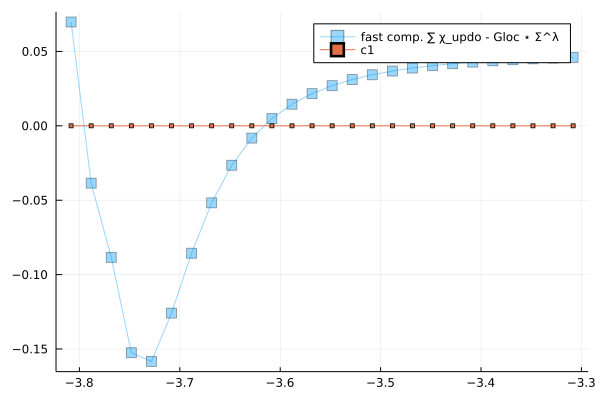

In [22]:
xarr = 2:length(λch_range)
#plot(λch_range[xarr], res[xarr,5] .- res[xarr,6], markershape=:square, markersize=2, label="∑ χ_updo - G^λ ⋆ Σ^λ")
plot(λch_range[xarr], res[xarr,5] .- res[xarr,7], markershape=:square, markersize=5, alpha=0.4, label="fast comp. ∑ χ_updo - Gloc ⋆ Σ^λ")
plot!(λch_range[xarr],res[xarr,3] .- res[xarr,4], markershape=:square, markersize=2, label="c1")
#savefig("conditions_new.pdf")
#plot!(λch_range, spOfch_max_nl, ylims=(-5,5), markershape=:circle, markersize=2, xlabel="λch", ylabel="λsp", label="")

In [ ]:
Σ_internal! = LadderDGA.Σ_internal!
χ_λ! = LadderDGA.χ_λ!
ν0Index_of_ωIndex = LadderDGA.ν0Index_of_ωIndex
conv_fft1 = LadderDGA.conv_fft1
kintegrate = LadderDGA.kintegrate
subtract_tail! = LadderDGA.subtract_tail!
expandKArr = LadderDGA.expandKArr
reduceKArr = LadderDGA.reduceKArr
fft = LadderDGA.fft
ifft = LadderDGA.ifft
fft! = LadderDGA.fft!
ifft! = LadderDGA.ifft!
iν_array = LadderDGA.iν_array
Naive = LadderDGA.Naive
extend_tmp! = LadderDGA.extend_tmp!
G_from_Σ = LadderDGA.G_from_Σ
gridshape = LadderDGA.gridshape
Σ_loc_pos = Σ_loc
Gνω = GLoc_fft

ωindices = (sP.dbg_full_eom_omega) ? (1:size(bubble,1)) : intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)

νmax = trunc(Int,size(bubble,3)/3)
νGrid = 0:(νmax-1)
iν_n = iν_array(mP.β, νGrid)
iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[ωindices] .* π ./ mP.β
sh_f = get_sum_helper(2*sP.n_iν, sP, :f)
sh_b = Naive() #get_sum_helper(length(ωindices), sP, :b)

tmp = Array{Float64,3}(undef, length(ωindices), size(bubble,2), size(bubble,3))
Σ_ladder_ω = SharedArray{Complex{Float64},3}(sP.n_iν, size(bubble,2), length(ωindices))
χupdo_ω = Array{eltype(nlQ_sp.χ),1}(undef, length(ωindices))
χupup_ω = Array{eltype(nlQ_sp.χ),1}(undef, length(ωindices))
χsp_int2 = Array{eltype(nlQ_sp.χ),2}(undef, size(nlQ_sp.χ)...)
χch_int2 = Array{eltype(nlQ_sp.χ),2}(undef, size(nlQ_sp.χ)...)


# Prepare data
Σ_internal!(tmp, ωindices, bubble, FUpDo, sh_f)
(sP.tc_type_f != :nothing) && extend_tmp!(tmp)

nh    = ceil(Int64, size(nlQ_sp.χ,1)/2)
χsp_min    = -1 / maximum(real.(nlQ_sp.χ[nh,:])) .+ 0.1
χch_min    = -1 / maximum(real.(nlQ_ch.χ[nh,:])) .+ 0.1

Σ_hartree = mP.n * mP.U/2
E_kin_tail_c = [zeros(size(kG.ϵkGrid)), (kG.ϵkGrid .+ Σ_hartree .- mP.μ)]
E_pot_tail_c = [zeros(size(kG.ϵkGrid)),
                (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (kG.ϵkGrid .+ Σ_hartree .- mP.μ))]
tail = [1 ./ (iν_n .^ n) for n in 1:length(E_kin_tail_c)]
E_pot_tail = sum(E_pot_tail_c[i]' .* tail[i] for i in 1:length(tail))
E_pot_tail_inv = sum((mP.β/2)  .* [Σ_hartree .* ones(size(kG.ϵkGrid)), (-mP.β/2) .* E_pot_tail_c[2]])


function cond_both_old!(F, λ)
    χ_λ!(χsp_int2, nlQ_sp.χ, λ[1], ωindices)
    χ_λ!(χch_int2, nlQ_ch.χ, λ[2], ωindices)

    for ωii in 1:length(ωindices)
        ωi = ωindices[ωii]
        ωn = (ωi - sP.n_iω) - 1
        fsp = 1.5 .* (1 .+ mP.U*χsp_int2[ωi, :])
        fch = 0.5 .* (1 .- mP.U*χch_int2[ωi, :])
        νZero = ν0Index_of_ωIndex(ωi, sP)
        maxn = minimum([νZero + sP.n_iν-1, size(tmp,3)])
        for (νn,νi) in enumerate(νZero:maxn)
            Kνωq = nlQ_sp.γ[ωi, :, νi] .* fsp .- nlQ_ch.γ[ωi, :, νi] .* fch .- 1.5 .+ 0.5 .+ tmp[ωii,:,νi]
            Σ_ladder_ω[νn,:, ωii] = conv_fft1(kG, Kνωq, view(Gνω, (νn-1) + ωn,:))
        end
    end
    E_pot = 0.0
    for qi in axes(bubble,2)
        GΣ_λ = 0.0
        for i in axes(νGrid,1)
            Σ_λ = mP.U * sum(@view Σ_ladder_ω[i,qi,:])/mP.β - Σ_ladderLoc[i] + Σ_loc_pos[i] + Σ_hartree
            GΣ_λ += 2 * real(Σ_λ * G_from_Σ(iν_n[i], mP.β, mP.μ, kG.ϵkGrid[qi], Σ_λ) - E_pot_tail[i,qi])
        end
        GΣ_λ += E_pot_tail_inv[qi]   # ν summation
        E_pot += kG.kMult[qi]*GΣ_λ # k intgration
    end
    E_pot = E_pot / (kG.Nk * mP.β)
    for (wi,w) in enumerate(ωindices)
        χupup_ω[wi] = kintegrate(kG, χch_int2[w,:] .+ χsp_int2[w,:])[1] / 2
        χupdo_ω[wi] = kintegrate(kG, χch_int2[w,:] .- χsp_int2[w,:])[1] / 2
    end
    subtract_tail!(χupup_ω, χupup_ω, mP.Ekin_DMFT, iωn)
    lhs_c1 = real(sum_freq(χupup_ω, [1], sh_b, mP.β, corr=-mP.Ekin_DMFT*mP.β^2/12)[1])
    lhs_c2 = real(sum_freq(χupdo_ω, [1], sh_b, mP.β)[1])
    println(lhs_c1, " ", lhs_c2)
    rhs_c1 = mP.n/2 * (1 - mP.n/2)
    rhs_c2 = E_pot/mP.U - (mP.n/2) * (mP.n/2)
    F[1] = lhs_c1 - rhs_c1
    F[2] = lhs_c2 - rhs_c2
end

In [ ]:
ωindices = (sP.dbg_full_eom_omega) ? (1:size(bubble,1)) : intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)

νmax = trunc(Int,size(bubble,3)/3)
νGrid = 0:(νmax-1)
iν_n = iν_array(mP.β, νGrid)
iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[ωindices] .* π ./ mP.β
iωn2_sub = real.([i == 0 ? 0 : mP.Ekin_DMFT ./ (i).^2 for i in iωn])
sh_f = get_sum_helper(2*sP.n_iν, sP, :f)
sh_b = Naive() #get_sum_helper(length(ωindices), sP, :b)

tmp = Array{Float64,3}(undef, length(ωindices), size(bubble,2), size(bubble,3))
Σ_ladder_ω = SharedArray{Complex{Float64},3}(sP.n_iν, size(bubble,2), length(ωindices))

χsp_int = SharedArray{eltype(nlQ_sp.χ),2}(length(ωindices), size(nlQ_sp.χ,2))
χch_int = SharedArray{eltype(nlQ_sp.χ),2}(length(ωindices), size(nlQ_sp.χ,2))


# Prepare data
Σ_internal!(tmp, ωindices, bubble, FUpDo, sh_f)
(sP.tc_type_f != :nothing) && extend_tmp!(tmp)

nh    = ceil(Int64, size(nlQ_sp.χ,1)/2)
χsp_min    = -1 / maximum(real.(nlQ_sp.χ[nh,:])) .+ 0.1
χch_min    = -1 / maximum(real.(nlQ_ch.χ[nh,:])) .+ 0.1

Σ_hartree = mP.n * mP.U/2
E_kin_tail_c = [zeros(size(kG.ϵkGrid)), (kG.ϵkGrid .+ Σ_hartree .- mP.μ)]
E_pot_tail_c = [zeros(size(kG.ϵkGrid)),
                (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (kG.ϵkGrid .+ Σ_hartree .- mP.μ))]
tail = [1 ./ (iν_n .^ n) for n in 1:length(E_kin_tail_c)]
E_pot_tail = sum(E_pot_tail_c[i]' .* tail[i] for i in 1:length(tail))
E_pot_tail_inv = sum((mP.β/2)  .* [Σ_hartree .* ones(size(kG.ϵkGrid)), (-mP.β/2) .* E_pot_tail_c[2]])


function cond_both!(F, λ)
    lhs_c1 = 0.0
    lhs_c2 = 0.0
    
    for ωii in 1:length(ωindices)
        ωi = ωindices[ωii]
        ωn = (ωi - sP.n_iω) - 1
        fsp = 1.5 .* (1 .+ mP.U ./ ((1.0 ./ view(nlQ_sp.χ, ωi,:)) .+ λ[1]))
        fch = 0.5 .* (1 .- mP.U ./ ((1.0 ./ view(nlQ_ch.χ, ωi,:)) .+ λ[2]))
        νZero = ν0Index_of_ωIndex(ωi, sP)
        maxn = minimum([νZero + sP.n_iν-1, size(tmp,3)])
        
        for (νn,νi) in enumerate(νZero:maxn)
            Kνωq = expandKArr(kG, view(nlQ_sp.γ,ωi, :, νi) .* fsp .- view(nlQ_ch.γ, ωi, :, νi) .* fch .- 1.5 .+ 0.5 .+ tmp[ωii,:,νi])
            fft!(Kνωq)
            Kνωq = Kνωq .* reshape(view(Gνω, (νn-1) + ωn,:), gridshape(kG))
            ifft!(Kνωq)
            Σ_ladder_ω[νn,:, ωii] = reduceKArr(kG, reverse(Kνωq))  ./ kG.Nk
        end
        t1 = 0.0
        t2 = 0.0
        for qi in axes(bubble,2)
            t1 += kG.kMult[qi]*real( 1.0 / ((1.0 / nlQ_ch.χ[ωi,qi]) .+ λ[2]))
            t2 += kG.kMult[qi]*real( 1.0 / ((1.0 / nlQ_sp.χ[ωi,qi]) .+ λ[1]))
        end
        lhs_c1 += (t1 + t2) / (2*kG.Nk) - iωn2_sub[ωii]
        lhs_c2 += (t1 - t2) / (2*kG.Nk)
    end
    E_pot = 0.0
    for qi in axes(bubble,2)
        GΣ_λ = 0.0
        for i in axes(νGrid,1)
            Σ_λ = mP.U * sum(view(Σ_ladder_ω, i,qi,:))/mP.β - Σ_ladderLoc[i] + Σ_loc_pos[i] + Σ_hartree
            GΣ_λ += 2 * real(Σ_λ * G_from_Σ(iν_n[i], mP.β, mP.μ, kG.ϵkGrid[qi], Σ_λ) - E_pot_tail[i,qi])
        end
        GΣ_λ += E_pot_tail_inv[qi]   # ν summation
        E_pot += kG.kMult[qi]*GΣ_λ # k intgration
    end
    E_pot = E_pot / (kG.Nk * mP.β)
    lhs_c1 = (lhs_c1 - mP.Ekin_DMFT*mP.β^2/12)/mP.β
    lhs_c2 = (lhs_c2)/mP.β
    println(lhs_c1, " ", lhs_c2)

    rhs_c1 = mP.n/2 * (1 - mP.n/2)
    rhs_c2 = E_pot/mP.U - (mP.n/2) * (mP.n/2)
    F[1] = lhs_c1 - rhs_c1
    F[2] = lhs_c2 - rhs_c2
    return F
end

In [ ]:
f1 = [1.0 3.1]
f2 = [1.0 3.1]
λttt = [0.1 3.2]
@time cond_both_old!(f1, λttt)
@time cond_both!(f2, λttt)
println("$f1 vs $f2 <=> $(f1 ≈ f2)")

In [ ]:
x0 = [λsp_min, λch_min]

function cond_both(λ)
    F = zeros(size(λ)...)
    cond_both!(F,λ)
    return F
end
@time LadderDGA.newton_2d_right(cond_both, x0, nsteps=100, atol=1e-6)

In [ ]:
cond_both([-0.001809180794405985, 1.0140624318248035])

In [ ]:
@time r = LadderDGA.extended_λ(nlQ_sp_nλ, nlQ_ch_nλ, bubble, GLoc_fft, FUpDo, Σ_loc, Σ_ladderLoc, kG, mP, sP)

In [ ]:
using Profile
using ProfileSVG
@profview cond_both!(f2, λttt)

In [ ]:
Σ_λ = Σ_ladder_corrected[1:νmax,:]
#Σ_λ = (Σ_ladder_i .- Σ_ladderLoc[1:size(Σ_ladder_i,1)] .+ Σ_loc[1:size(Σ_ladder_i,1)]);
E_kin_DGA, E_pot_DGA_i = LadderDGA.calc_E(Σ_λ, kGrid, mP, sP)
#E3 = LadderDGA.calc_E_pot(kG, GLoc[0:νmax-1,:].parent, Σ_λ, E_pot_tail, E_pot_tail_inv, mP.β)
Σ_λ .= Σ_λ .+ Σ_hartree
G_λ = flatten_2D(G_from_Σ(Σ_λ, kG.ϵkGrid, 0:νmax-1, mP));
E3_h = real.(G_λ .* Σ_λ .- E_pot_tail);
E3 = kintegrate(kG, 2 .* sum(E3_h[1:size(Σ_λ,1),:], dims=[1])[1,:] .+ E_pot_tail_inv)[1] / mP.β
E4 = LadderDGA.calc_E_pot(kG, G_λ, Σ_λ, E_pot_tail, E_pot_tail_inv, mP.β);

In [ ]:
ep1 = map(x-> x[1], E_pot_DGA_i)
ep2 = map(x-> x[1], E3)
ep3 = map(x-> x[1], E4)
plot(ep1,markershape=:auto, markersize=6, label="full")
hline!([E3], label="fast 1")
hline!([E4], label="fast")

322.476980 seconds (1.13 G allocations: 254.027 GiB, 16.14% gc time, 0.06% compilation time)


# extended Lambda test
TODO: reactivate plots

In [ ]:
mP = LadderDGA.modelParams
sP = LadderDGA.simParams
nc = [0,1,2,3]
NW = floor(Int64, length(usable_ω)/2)
ωmin = 1
ωmax = NW 
coeffs = collect(0:3)
Wω = LadderDGA.build_weights(ωmin, ωmax, coeffs)
println("building  weight matrix from $ωmin to $ωmax with coefficients $(coeffs)")
include("src/ConvergenceAcc.jl")
#Shanks.shanks(E_Pot, csum_inp=true) 

testf_c2(λspi , λchi) = LadderDGA.calc_E_pot_cond(λspi , λchi, nlQ_sp, nlQ_ch, bubble, 
                         LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                         LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                         LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                         mP, sP, sP.tail_corrected);
function cond_both_nc!(F, λ)
    testf!(λ) = construct_f(λ[1],λchi, rχsp, rχch, mode=m, rhs=rhs_val)
    testdf!(λ) = construct_df(λ[1], λchi, rχsp, rχch, mode=m, rhs=rhs_val);
    Σ_ladder2, lhs_c2, E_pot_DGA = testf_c2(λ[1], λ[2])
    χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ), λ[1])
    χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ), λ[2])
    χupup = LadderDGA.sum_q(χch_λ[usable_ω,:].+ χsp_λ[usable_ω,:], LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
    nwh = ceil(Int64, size(χsp_λ,1)/2)
    penalty = sum(abs.(χsp_λ[nwh,(χsp_λ[nwh,:] .< 0)])) + sum(abs.(χch_λ[nwh,(χch_λ[nwh,:] .< 0)])) 
    #penalty2 = length(χch_λ[nwh,((χch_λ[nwh,:] .< 0.01) .& (χch_λ[nwh,:] .>= 0.0))])
    tmp =  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1]) 
    #tmp += -penalty
    lhs_c1 = (mP.n/2) * (1 - mP.n/2)
    println("calling for λ=$λ, E_pot=$(E_pot_DGA), penalty = $penalty")
    F[1] = penalty > 0 ? penalty : tmp - lhs_c1
    F[2] = (lhs_c2) - E_pot_DGA# - penalty
end

function cond_both_c!(F, λ)
    Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(λ[1], λ[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=true);
    χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ), λ[1])
    χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ), λ[2])
    χupup = LadderDGA.sum_q(χch_λ[usable_ω,:].+ χsp_λ[usable_ω,:], LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
    nwh = ceil(Int64, size(χsp_λ,1)/2)
    penalty = sum(abs.(χsp_λ[nwh,(χsp_λ[nwh,:] .< 0)])) + sum(abs.(χch_λ[nwh,(χch_λ[nwh,:] .< 0)])) 
    #penalty2 = length(χch_λ[nwh,((χch_λ[nwh,:] .< 0.01) .& (χch_λ[nwh,:] .>= 0.0))])
    tmp =  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1]) 
    #tmp += -penalty
    lhs_c1 = mP.n/2 * (1 - mP.n/2)
    println("calling for λ=$(round.(λ,digits=2)), E_pot=$(E_pot_DGA), res = $(abs(tmp - lhs_c1) + abs(E_pot_DGA + (lhs_c2))), penalty = $penalty")
    F[1] = penalty > 0 ? penalty : tmp - lhs_c1
    F[2] = (lhs_c2) - E_pot_DGA
    #F[3] = mP.n - sum(Gμλ)
end

In [ ]:
using LaTeXStrings
χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), res_nc.zero[1])
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), res_nc.zero[2])
χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
χupdo = LadderDGA.sum_q(χch_λ .- χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω)[1])  + mP.n^2/4
lhs_c1 = mP.n/2 * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(res_nc.zero[1], res_nc.zero[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=false);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);


l = @layout [A{0.01h}; 
             [grid(1,2)
              b{0.3h}]]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β)", grid = false, showaxis = false, bottom_margin = -50Plots.px)
p1 = plot(xarr, χsp_λ[:,1], legend = true, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", :right, 10))

    
p2 = plot(xarr, χch_λ[:,1], legend = false, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", :right, 10))


p3 = plot(E_Pot, xlabel=L"\nu_n", label=L"\qquad\qquad\;\;\; G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))", markershape=:hexagon, markersize=2,legend=:bottomright, legendfontsize=9)
plot!([rhs_c2], seriestype = :hline, label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\quad\, = %$(round(rhs_c2, digits=6))")
plot!([E_Pot[end]], seriestype = :hline, linestyle=:dash, label=L"\mathrm{\;\;\;naive\;E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA, digits=6))")
annotate_y_pos = (0.3*(maximum(E_Pot) - minimum(E_Pot)) + minimum(E_Pot))
annotate!(0.2*length(E_Pot), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=14)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 10))

plot(title, p1, p2, p3, layout = l, size=(1000,800))
#savefig("cond_solution_tc_test_b15U2.pdf")

In [ ]:
using LaTeXStrings

χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), res_nc.zero[1])
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), res_nc.zero[2])
χsp_λ_old = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]),0.050817859568877091)
χch_λ_old = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), 0.0)
χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
χupdo = LadderDGA.sum_q(χch_λ .- χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω)[1])  + mP.n^2/4
lhs_c1 = mP.n/2 * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(res_nc.zero[1], res_nc.zero[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=false);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);
E_Kin_naive, E_Pot_naive = calc_E_notail(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);
l = @layout [A{0.025h}; 
             grid(1,2)]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β)", grid = false, showaxis = false, bottom_margin = -50Plots.px, titlefontsize=18)
p1 = plot(xarr, χsp_λ_old[:,end], label=L"\mathrm{Old\;Method:}\;\; \lambda_\mathrm{sp} = 0.051", markershape=:circle, markersize=3, markerstrokewidth=0.6)
plot!(xarr, χsp_λ[:,end], color=:orange, legend = :outertop, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label=L"\mathrm{New\;Method:}\; \lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", markershape=:hexagon, markerstrokewidth=0.6, markersize=3,
    xtickfontsize=12,ytickfontsize=12,legendfontsize=12,xguidefontsize=16,yguidefontsize=16, margin=4Plots.mm)
#plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
#p1 = plot(xarr, χsp_λ[:,end], label=L"q=$(\pi,\pi,\pi)", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
#annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", :right, 10))
annotate!(xarr[end-2], annotate_y_pos, text(L"\vec{q}=(\pi,\pi,\pi)", :right, 16))
    
p2 = plot(xarr, χch_λ_old[:,end], label=L"\mathrm{Old\;Method:}\;\; \lambda_\mathrm{ch} = 0", markershape=:circle, markersize=3, markerstrokewidth=0.6)
plot!(xarr, χch_λ[:,end], color=:orange, legend = :outertop, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label=L"\mathrm{New\;Method:}\; \lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", markershape=:hexagon, markersize=3, markerstrokewidth=0.6,xtickfontsize=12,ytickfontsize=12,legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
#plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
#plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
#annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", :right, 10))
annotate!(xarr[end-2], annotate_y_pos, text(L"\vec{q}=(\pi,\pi,\pi)", :right, 16))



plot(title, p1, p2, layout = l, size=(1200,600))
#savefig("cond_solution_tc_test_b25U1.pdf")

In [ ]:
l2 = @layout [A{0.025h}; 
             grid(2,1)]

t = [real(mP.U * real(LadderDGA.sum_freq(χupdo[i+1:(end-i)], [1], true, mP.β, weights=LadderDGA.build_weights(1, floor(Int64, size(χupup[i+1:(end-i)], 1)/2), collect(0:3)))[1])  + mP.n^2/4) for i in 8:-1:0]

nanline = repeat([NaN], length(E_Pot))
p3 = plot(E_Pot_naive, xlabel=L"\nu_\mathrm{max}", 
    label=L"\;\;\;\frac{1}{\beta N_k}\sum_{\nu,q} G^\lambda \star \Sigma^\lambda\, = %$(round(E_Pot_naive[end], digits=6))",
    markershape=:hexagon, markersize=2, markerstrokewidth=0.4,legend=:bottomright, margin=1Plots.mm,
    xtickfontsize=12,ytickfontsize=12, legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
plot!(nanline, label=" ", alpha= 0.0)
#[rhs_c2], seriestype = :hline
plot!(nh-9:nh-1,t,markershape=:hexagon, color=:orange, markersize=4, markerstrokewidth=0.4, label=L"\quad\;\mathrm{SumFit}_{\omega}[\chi_\mathrm{up, do}] = %$(round(rhs_c2, digits=6))")
plot!([rhs_c2], seriestype = :hline, label=nothing, color=:orange)
plot!(nanline, label=" ", alpha= 0.0)
plot!([E_Pot], markershape=:hexagon, markersize=2, markerstrokewidth=0.4, 
    label=L"{\mathrm{SumFit}_{\nu}[G^\lambda \star \Sigma^\lambda]\, = %$(round(E_Pot[end], digits=6))}")

naive_chiupup_sum = (χupup[nh] .+ 2 .* cumsum(χupup[nh+1:end])) ./ mP.β
tt = [real(LadderDGA.sum_freq(χupup[i+1:(end-i)], [1], true, mP.β, weights=LadderDGA.build_weights(1, floor(Int64, size(χupup[i+1:(end-i)], 1)/2), collect(0:3)))[1]) for i in 8:-1:0]
real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1]) 

nanline = repeat([NaN], length(tt))
p4 = plot(1:nh-1,naive_chiupup_sum, xlabel=L"\omega_\mathrm{max}", 
    label=L"\;\;\;\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} =   %$(round(naive_chiupup_sum[end],digits=4))", xticks=collect(1:nh-1), margin=5Plots.mm,
    markershape=:hexagon, markersize=2, markerstrokewidth=0.4,legend=:bottomright,xtickfontsize=12,ytickfontsize=12, legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
plot!(nanline, label=" ", alpha= 0.0)
plot!(nh-9:nh-1,tt,markershape=:hexagon, markersize=2, markerstrokewidth=0.4, color=:orange, label=L"\mathrm{SumFit}_{\omega}[\chi_\mathrm{up, up}] = %$(round(rhs_c1,digits=4))")
plot!(nanline, label=" ", alpha= 0.0)

plot!([0.25], seriestype = :hline, color=:green, label=L"\qquad\;\frac{n}{2}\left({1-\frac{n}{2}}\right) = \frac{1}{4}")
annotate_y_pos = (0.08*(maximum(χupup) - minimum(χupup)) + minimum(χupup))
#annotate!(0.3*length(1:nh-1), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=12)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 14))

plot(title, p3, p4, layout = l2, size=(1200,600))
#savefig("cond_solution_tc_test_b25U1_2.pdf")

In [ ]:
using LaTeXStrings
usable_ω = ωindices
lsp_zero = 0.04856121321074435#res_c.zero[1]
lch_zero = 0.1292099471786603#res_c.zero[2]
χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), lsp_zero)
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), lch_zero)
χupup = LadderDGA.kintegrate(qG, χch_λ .+ χsp_λ, dim=2)[:,1] ./ 2
χupdo = LadderDGA.kintegrate(qG, χch_λ .- χsp_λ, dim=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], Naive(), mP.β)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], Naive(), mP.β)[1])  + mP.n^2/4
lhs_c1 = (mP.n/2) * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(lsp_zero, lch_zero, nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=true);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);

l = @layout [A{0.01h}; 
             [grid(1,2)
              b{0.3h}]]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β), \mathrm{E}_\mathrm{pot} \mathrm{\;extrapolated}", grid = false, showaxis = false, bottom_margin = -50Plots.px)
p1 = plot(xarr, χsp_λ[:,1], legend = true, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(lsp_zero,digits=3))", :right, 10))
    
p2 = plot(xarr, χch_λ[:,1], legend = false, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(lch_zero,digits=3))", :right, 10))


p3 = plot(E_Pot, xlabel=L"\nu_n", label=L"\qquad\qquad\;\;\; G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))", markershape=:hexagon, markersize=2,legend=:bottomright, legendfontsize=10)
plot!(repeat([rhs_c2], length(E_Pot)), label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\quad\, = %$(round(rhs_c2, digits=6))")
#plot!([E_pot_DGA[1]], seriestype = :hline, linestyle=:dash, label=L"\qquad\qquad\mathrm{E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA[1], digits=6))")
plot!([E_Pot[end]], seriestype = :hline, linestyle=:dash, label=L"\mathrm{\;\;\;naive\;E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA[1], digits=6))")
annotate_y_pos = (0.3*(maximum(E_Pot) - minimum(E_Pot)) + minimum(E_Pot))
annotate!(0.2*length(E_Pot), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=14)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 10))

plot(title, p1, p2, p3, layout = l, size=(1000,800))
savefig("cond_solution_tc_test_b25U1.pdf")

# q-dependent correction

- compute $E_\text{kin,lDGA}$
- subtract $\frac{E_\text{kin,DMFT}}{i\omega^2}$ tail to $\chi_{\uparrow\downarrow}$
- add $\frac{E_\text{kin,lDGA}}{i\omega^2}$
- compute $E_\text{kin,lDGA}$, if not convergd, start over

In [ ]:
using LsqFit
tail_func(iωn, c)  = sum([c[n] ./ (iωn .^ (n-1)) for n in 1:length(c)])
tail_func_n0(iωn, c)  = sum([c[n] ./ (iωn .^ (n)) for n in 1:length(c)])
tail_func_real(iωn, c)  = real(sum([c[n] ./ (iωn .^ (n-1)) for n in 1:length(c)]))
tail_func_real_n0(iωn, c)  = real(sum([c[n] ./ (iωn .^ (n)) for n in 1:length(c)]))

tail_func(iωn, c) = sum([c[n] ./ (iωn .^ (n-1)) for n in 1:length(c)])
tail_func_r(iωn, c) = real(sum([c[n] ./ (iωn .^ (n-1)) for n in 1:length(c)]))
tail_func_0(iωn, c) = c ./ (iωn .^ 0)
tail_func_1(iωn, c) = c ./ (iωn .^ 1)
tail_func_2(iωn, c) = real.(c ./ (iωn .^ 2))

rχsp = real.(nlQ_sp_nλ.χ)
rχch = real.(nlQ_ch_nλ.χ)
rχupup = 0.5 .* real.(rχsp .+ rχch)

nh   = ceil(Int64, size(rχsp,1)/2) + 20
ωindices_q = nh:last(ωindices)
min_ω = 1
qind = 1
p2 = [1.0]
p0_2 = [0.0, 0.0, 1.0]
p0_4 = [0.0, 0.0, 1.0, 0.0, 1.0]
p1_2 = [0.0, 1.0]
p1_4 = [0.0, 1.0, 0.0, 1.0]
iω_arr = LadderDGA.iω_array(mP.β, -sP.n_iω:sP.n_iω)[ωindices_q];

In [ ]:
#Tests for setup below

fit_only2 = curve_fit(tail_func_2, iω_arr, rχsp[ωindices_q,1], p2)   
fit_0to2 = curve_fit(tail_func_real, iω_arr, rχsp[ωindices_q,1], p0_2); 
println("Results for fit of χsp(ω, q=(0,0,0)) fit:")
println("Fit only 2 converged = $(fit_only2.converged) with result $(round.(fit_only2.param,digits=5)).\nFit 0 to 4 converged = $(fit_0to2.converged) with result $(round.(fit_0to2.param,digits=5))")